# Quantum Integral Computation using AE

We are going to define a Benchmark for *Amplitude Estimation* (**AE**) techniques.

## Formal description of the problem 

The problem we proposed for the benchamark is the computation of the integral of function $f$ in a closed interval $[a, b] \subset \mathbf{R}$:

$$I = \int_a^bf(x)dx$$

For computing this integral in a numeric way we are going to use a Monte Carlo integration approach. Let $L$ be:

$$L = \int_a^bdx$$

The naive Monte Carlo aproximation consit in sample $N$ points, in an uniform way, form interval $[a,b]$:

$$x_0, x_2, ..., x_{N-1} \in [a,b]$$

The desired integral can be approximated by:


$$I= \int_a^bf(x)dx \approx I_{MC} = \frac{L}{N}\sum_{i=0}^{i=N-1}f(x_i)$$

The error of the Monte Carlo integration estimation  will be:

$$\epsilon_{MC} = \frac{1}{\sqrt{N}}$$

When using $\textbf{AE}$ techniques is expected that the error of this aproximation scales as

$$\epsilon_{AE} = \frac{1}{N}$$

In order to use $\textbf{AE}$ techniques we need to approximate the integral as a Riemman sum: let 

$$P=\{[x_0, x_1], [x_1, x_2], ..., [x_{n-1}, x_n]\}$$ 

such that:

$$a = x_0 < x_1 < x_2 < ... < x_n=b$$

Then 

$$I= \int_a^bf(x)dx \approx S = \sum_i^nf(x_i)*\Delta x_i$$

In [4]:
import sys
sys.path.append("../")
sys.path.append("../../benchmark/")
import numpy as np
import pandas as pd
import qat.lang.AQASM as qlm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate

In [5]:
#This cell loads the QLM solver.
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg (for using QPU as CESGA QLM one)
from QQuantLib.utils.qlm_solver import get_qpu
QLMaaS = False
linalg_qpu = get_qpu(QLMaaS)

Using default qpu


In [6]:
from QQuantLib.utils.data_extracting  import get_results

## 1.Monte Carlo clásico

De momento vamos a lanzar una cosa tonta para ajustar todo lo que podemos necesitar:

$$f(x) = \sin x$$

$$I = \int_a^{b}\sin(x)dx = -\cos x |_a^b = \cos(a)-\cos(b)$$

In [7]:
def f(x):
    return np.sin(x)
def MonteCarlo(f, x0, xf, N):
    mc_domain = (xf-x0)*np.random.rand(N) + x0
    mc_integration = (xf-x0) * np.mean(f(mc_domain))
    return mc_integration
def sin_integral(a,b):
    return np.cos(a)-np.cos(b)

In [8]:
a = np.pi/4.0
b = np.pi/2.0

In [9]:
MonteCarlo(np.sin, a, b, 1000)

0.7045230279664791

In [10]:
sin_integral(a,b)

0.7071067811865475

In the following cell we show the behaviour of the MC integration when number of samples is increased.

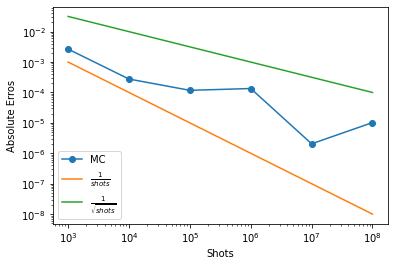

In [11]:
ListOfShots_MC = [1.0e3, 1.0e4, 1.0e5, 1.0e6, 1.0e7, 1.0e8]

MC = []
for shots in ListOfShots:
    MC.append(MonteCarlo(np.sin, a, b, int(shots)))
    
plt.plot(ListOfShots, abs(MC-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots, 1.0/np.array(ListOfShots))
plt.plot(ListOfShots, 1/np.sqrt(np.array(ListOfShots)))
plt.xlabel('Shots')
plt.xscale('log')
plt.ylabel('Absolute Erros')
plt.yscale('log')    
plt.legend(['MC', r'$\frac{1}{shots}$', r'$\frac{1}{\sqrt{shots}}$'])

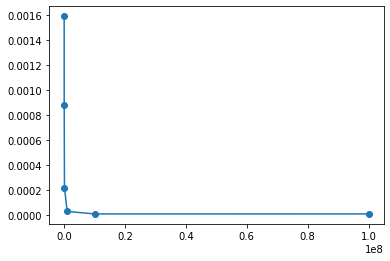

In [66]:
ListOfShots_MC = [1.0e3, 1.0e4, 1.0e5, 1.0e6, 1.0e7, 1.0e8]
MC = []
for shots in ListOfShots_MC:
    MC.append(MonteCarlo(np.sin, a, b, int(shots)))
plt.plot(ListOfShots_MC, abs(MC-sin_integral(a,b)), 'o-')

## 3. MonteCarlo Cuántico

Vamos a codificar la función que tenemos que integrar $f(x)$ en un circuito cuántico con el fin de poder posteriormente aplicar técnicas de $\textbf{AE}$ que me permitan obtener la integral deseada. Lo pirmero que necesitamos es codificar adecuadamente la función a integrar $f(x)$ en un circuito.

### 3.1 Discretización del Dominio.

Como nos interesa calcula el valor de la integral en el dominio $[a,b]$ lo primero que necesitamos es discretizar dicho dominio en $2^n$ intervalos:

$$P=\{[x_0, x_1], [x_1, x_2], ..., [x_{2^n-1}, x_{2^n}]\}$$ 

Verificándose que:

1. $x_{i+1} < x_{i}$
2. $a = x_0$
3. $b = x_{2^n}$


In [12]:
n = 6

In [13]:
domain_x = np.linspace(a, b, 2**n+1)

In [98]:
type(domain_x)

numpy.ndarray

In [102]:
type(domain_x) is np.ndarray

True

### 3.2 Discretización de la función

Utilizando la discretización del dominio procedemos a calcular los dos siguientes arrays de valores:

1. $\Delta x_i = x_{i+1} - x_{i}$
2. $f_{x_i} = \frac{f(x_{i+1}) + f(x_{i})}{2}$

A partir de estos dos arrays podriamos crear una suma de Riemman:

$$S_{[a,b]} = \sum_{i=0}^{2^n-1} f_{x_i} \Delta x_i$$

De tal modo que $\Delta x_i \rightarrow 0$ entonces $I \approx S_{[a,b]}$

Procedemos a crear el siguiente array 

$$
    g_{x_i} = f_{x_i} \Delta x_i 
\tag{1}
$$ 


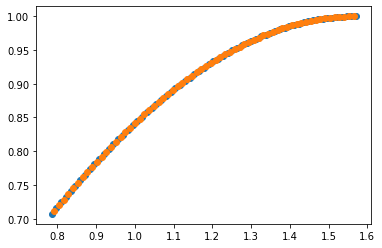

In [15]:
delta_x = np.diff(domain_x)
f_x = []
x_ = []
for i in range(1, len(domain_x)):
    step_f = (f(domain_x[i]) + f(domain_x[i-1]))/2.0
    #print(i)
    f_x.append(step_f)
    x_.append((domain_x[i] + domain_x[i-1])/2.0)
f_x = np.array(f_x)
x_ = np.array(x_)

plt.plot(domain_x, f(domain_x), 'o')
plt.plot(x_, f_x, 'o')

g_x = f_x*delta_x

In [16]:
#Numerical integral
np.sum(g_x)

0.7070979070795471

### 3.3 Normalizacion de la función

Antes de continuar es conveniente realizar una normalización del array $g_{x_i}$ de tal modo que:

$$g\_norm_{x_i} = \frac{g_{x_i}}{\max(g_{x_i})} \tag{2} $$

In [17]:
normalization= max(g_x)
print(normalization)
#normalization = 1.0
g_norm_x = g_x/normalization

0.012271384279356626


### 3.4 Codificacion en el circuito cuántico.

La idea es codificar la función $g\_norm_{x_i}$ en un circuito cuántico. 



In [20]:
from encoding_protocols import Encoding

#### 3.4.1. Standard Encoding procedure

El procedimiento de carga será:

1. Se Inicializan $n+1$ qbits: 

$$|0\rangle^n\otimes|0\rangle$$

2. Se Aplican puertas Haddamard sobre los $n$ primeros qbits: 

$$(H^{\otimes n} \otimes I)|0\rangle^n\otimes|0\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle\otimes|0\rangle \tag{3}$$

3. Se utiliza un operador $\mathbf{U}_f$ que permita la carga del array el operador $g\_norm_{x_i}$ en el circuito cuántico. Sea $f(x)$ una función dicho operador realizaría la siguiente transformación:

$$\mathbf{U}_f|x\rangle|0\rangle = |x\rangle\left(\sqrt{f(x)}|0\rangle + \sqrt{1-f(x)}|1\rangle \right) \tag{4}$$


Así pues si ejcutamos los 3 anteriores pasos obtendríamos un estado $|\Psi\rangle$ tal que:


$$|\Psi\rangle = \mathbf{U}_{g\_norm_{x_i}}\left( \left( H^{\otimes n} \otimes I \right) |0\rangle^n\otimes|0\rangle \right) \tag{5}$$


Vamos a desarrollar el estado $|\Psi \rangle$. Aplicando $(3)$ en $(5)$:

$$|\Psi\rangle = \mathbf{U}_{g\_norm_{x_i}} \left( \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle\otimes|0\rangle  \right) = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} \mathbf{U}_{g\_norm_{x_i}}|i\rangle\otimes|0\rangle $$

Si aplicamos $(4)$:


$$|\Psi\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle \left[ \sqrt{g\_norm_{x_i}}|0\rangle + \sqrt{1-g\_norm_{x_i}} |1\rangle \right] = $$

Separando las contribuciones del qbit adicional en $|0\rangle$ y $|1\rangle$:

$$|\Psi\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}\sqrt{g\_norm_{x_i}} |i\rangle |0\rangle + \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}\sqrt{1-g\_norm_{x_i}} |i\rangle |1\rangle \tag{6}$$

 
La probabililidad de medir el estado $|0\rangle$ cuando se mide el qbit adiciobal vendrá dada por:

$$\mathbf{P}_{|0 \rangle} = \sum_{j=0}^{2^n-1}\mathbf{P}_{|j\rangle^n|0\rangle} \tag{7}$$
Donde:

$$\mathbf{P}_{|j\rangle^n|0\rangle} =\left| \; ^n\langle j | \otimes \langle 0|\Psi\rangle \; \right|^2$$

Utilizando $(6)$ y que $\langle 1|0\rangle = 0$:

$$\mathbf{P}_{|j\rangle^n|0\rangle} = \left| \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n+1}\sqrt{g\_norm_{x_i}}\; ^n\langle j|i\rangle^n \langle 0|0\rangle \right|^2 $$

Utilizando que $^n\langle j|i\rangle^n = \delta_{ji}$:

$$\mathbf{P}_{|j\rangle^n|0\rangle} = \left| \frac{1}{\sqrt{2^n}}\sqrt{g\_norm_{x_j}}\right|^2 = \left|\frac{g\_norm_{x_j}}{2^n}\right| \tag{8}$$

Así pues utilizando $(8)$ en $(7)$:

$$\mathbf{P}_{|0 \rangle} =  \sum_{j=0}^{2^n-1} \left|\frac{g\_norm_{x_j}}{2^n}\right|$$

Si ahora deshacemos $(2)$

$$\mathbf{P}_{|0 \rangle} =  \sum_{j=0}^{2^n-1} \left| \frac{g_{x_j}}{\max(g_{x_j})2^n} \right|$$

Si ahora deshacemos $(1)$:

$$\mathbf{P}_{|0 \rangle} =  \sum_{j=0}^{2^n-1} \left| \frac{f_{x_j}\Delta x_j}{\max(g_{x_j})2^n} \right|$$

Así pues en la amplitud del estado $|0\rangle$ del qbit adicional se ha conseguido codificar un valor proporcional a la integral de Riemman!!:


$$S_{[a,b]} = \sum_{i=0}^{2^n-1} f_{x_i} \Delta x_i = 2^n \max(g_{x_i}) \mathbf{P}_{|0 \rangle} \tag{9}$$

In [22]:
#Standard Encoding
standard_encoding = Encoding(array_function=g_norm_x, array_probability=None)
standard_encoding.oracle_encoding_01()

In [23]:
oracle = standard_encoding.oracle
%qatdisplay oracle

Now the desired result is enconding in the state $|0\rangle$ of the additional qbit. Using $(9)$

In [27]:
encoding01_results,_,_,_ = get_results(standard_encoding.oracle, linalg_qpu= linalg_qpu , qubits=standard_encoding.co_index)

In [28]:
encoding01_results

,States,Int_lsb,Probability,Amplitude,Int
0,|0>,0,0.900339,NaN,0
1,|1>,1,0.099661,NaN,1


In [46]:
P_0 = encoding01_results['Probability'].iloc[0]
quantum_integral = normalization*(2**n)*P_0
print("Integral encoding in the |0> state of the additional qbits: {}".format(quantum_integral))
print("Integral by pure Riemman sum: {}".format(np.sum(g_x)))
N_MC = 1e8
print("Integral by Classical Monte Carlo ({}): {}".format(N_MC, MonteCarlo(np.sin, a, b, int(N_MC))))
print("Exact Integral: {}".format(sin_integral(a,b)))

Integral encoding in the |0> state of the additional qbits: 0.7070979070795463
Integral by pure Riemman sum: 0.7070979070795471
Integral by Classical Monte Carlo (100000000.0): 0.7071030914887056
Exact Integral: 0.7071067811865475


In [47]:
print("Error for exact integral: {}".format(abs(quantum_integral-sin_integral(a,b))))
N_MC = 1e8
print("Error for Classical Monte Carlo ({}): {}".format(N_MC, abs(quantum_integral-MonteCarlo(np.sin, a, b, int(N_MC)))))
print("Error for pure Riemman sum: {}".format(abs(quantum_integral-np.sum(g_x))))

Error for exact integral: 8.874107001122233e-06
Error for Classical Monte Carlo (100000000.0): 2.9578528619733646e-06
Error for pure Riemman sum: 7.771561172376096e-16


#### 3.4.2 New Encoding Procedure

Encoding protocol:

1. $n+1$ qbits will be initialised: 

$$|0\rangle^n\otimes|0\rangle$$

2. Haddamard gates will be applied over the $n$ first qbits: 

$$(H^{\otimes n} \otimes I)|0\rangle^n\otimes|0\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle\otimes|0\rangle \tag{10}$$

3. Let be $f(x)$ a function the operator $\mathbf{U}_f$ will be defined following $(10)$ (**BE AWARE** in equation $(4)$ the $\sqrt{f(x)}$ was used for the operator)

$$\mathbf{U}_f|x\rangle|0\rangle = |x\rangle\left(f(x)|0\rangle + \sqrt{1-f^2(x)}|1\rangle \right) \tag{11}$$

4. Using opertator $\mathbf{U}_f$ and let $f(x) = g\_norm_{x_i}$ on the quantum circuit following $(12)$:

$$\mathbf{U}_{g\_norm_{x_i}}\left( \left( H^{\otimes n} \otimes I \right) |0\rangle^n\otimes|0\rangle \right) \tag{12}$$

5. Haddamard gates will be applied over the $n$ first qbits again:

$$|\Psi\rangle = \left( \left( H^{\otimes n} \otimes I \right) \mathbf{U}_{g\_norm_{x_i}} \left( H^{\otimes n} \otimes I \right)\right) |0\rangle^n\otimes|0\rangle  \tag{13}$$

So using $(10)$ in $(13)$:

$$|\Psi\rangle =\left( \left( H^{\otimes n} \otimes I \right) \mathbf{U}_{g\_norm_{x_i}} \right) \left( \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle\otimes|0\rangle  \right) =  \left( H^{\otimes n} \otimes I \right) \left(  \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} \mathbf{U}_{g\_norm_{x_i}}|i\rangle\otimes|0\rangle \right) \tag{14}$$

Now $(11)$ will be applied on $(14)$:


$$|\Psi\rangle = \left( H^{\otimes n} \otimes I \right)  \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1}|i\rangle \left[ g\_norm_{x_i}|0\rangle + \sqrt{1-g^2\_norm_{x_i}} |1\rangle \right] \tag{15}$$

So

$$|\Psi\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} g\_norm_{x_i} \left( H^{\otimes n} \otimes I \right) |i\rangle |0\rangle + \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} \sqrt{1-g^2\_norm_{x_i}} \left( H^{\otimes n} \otimes I \right) |i\rangle |0\rangle $$

The secon term ($\frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} \sqrt{1-g^2\_norm_{x_i}} \left( H^{\otimes n} \otimes I \right) |i\rangle |0\rangle$) is not interested for our purpouses so we can write following equation:

$$|\Psi\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n+1} g\_norm_{x_i} \left( H^{\otimes n} \otimes I \right) |i\rangle |0\rangle + ... \tag{16}$$

Using:

$$H^{\otimes n} |i\rangle = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n}\sum_{k=0}^{2^n} (-1)^{jk} |j\rangle \langle k|i\rangle = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n} (-1)^{ji} |j\rangle$$

in $(16)$:

$$|\Psi\rangle = \frac{1}{2^n} \sum_{i=0}^{2^n+1} g\_norm_{x_i} \sum_{j=0}^{2^n} (-1)^{ji} |j\rangle |0\rangle + ... \tag{17}$$

Expliciting the $j$ sumation:

$$|\Psi\rangle = \frac{1}{2^n} \sum_{i=0}^{2^n+1} g\_norm_{x_i} |0\rangle^n |0\rangle + \sum_{j=1}^{2^n} (-1)^{ji} |j\rangle |0\rangle + ... $$

Again sumation for $j\geq1$ are not interested for us so we can write down the equation $(18)$:

$$|\Psi\rangle = \frac{1}{2^n} \sum_{i=0}^{2^n+1} g\_norm_{x_i} |0\rangle^n |0\rangle  + ...  = \frac{1}{2^n} \sum_{i=0}^{2^n+1} g\_norm_{x_i} |0\rangle^{n+1} + ... \tag{18}$$

Now the probability of measuring the state $|0\rangle^n |0\rangle$ will be:


$$\mathbf{P}_{|0\rangle^n|0\rangle} = \mathbf{P}_{|0\rangle^{n+1}} =\left| \; ^{n+1}\langle 0 |\Psi\rangle \; \right|^2 $$

Using $(18)$:

$$ \mathbf{P}_{|0\rangle^{n+1}} = \left| \; ^{n+1}\langle 0 | \frac{1}{2^n} \sum_{i=0}^{2^n+1} g\_norm_{x_i} |0\rangle^{n+1}\; \right|^2$$

$$\mathbf{P}_{|0\rangle^{n+1}} = \left| \; \frac{1}{2^n} \sum_{i=0}^{2^n+1} \; g\_norm_{x_i} \right|^2$$

So:

$$2^n \sqrt{\mathbf{P}_{|0\rangle^{n+1}}} =  \sum_{i=0}^{2^n+1} \; g\_norm_{x_i} $$

Using $(2)$:


$$2^n \sqrt{\mathbf{P}_{|0\rangle^{n+1}}} =  \sum_{i=0}^{2^n+1} \; \frac{g_{x_i}}{\max(g_{x_i})} $$
  
And using $(1)$:


$$2^n \sqrt{\mathbf{P}_{|0\rangle^{n+1}}} =  \sum_{i=0}^{2^n+1} \; \frac{f_{x_i} \Delta x_i }{\max(g_{x_i})} $$

So finally the amplitud of the state $|0\rangle^{n+1}$ codifies the desired integral using equation $(19)$:


$$S_{[a,b]} = \sum_{i=0}^{2^n-1} f_{x_i} \Delta x_i = 2^n \max(g_{x_i}) \sqrt{\mathbf{P}_{|0 \rangle^{n+1}}} \tag{19}$$

In [50]:
#New Encoding
new_encoding = Encoding(array_function=g_norm_x, array_probability=None)
new_encoding.oracle_encoding_03()

In [51]:
oracle = new_encoding.oracle
%qatdisplay oracle

In [53]:
encoding02_results,_,_,_ = get_results(new_encoding.oracle, linalg_qpu= linalg_qpu , qubits=new_encoding.co_index)

In [54]:
encoding02_results

,States,Int_lsb,Probability,Amplitude,Int
0,|0000000>,0,0.810610,0.900339+0.000000j,0
1,|0000001>,1,0.000005,-0.002288+0.000000j,64
2,|0000010>,2,0.000021,-0.004577+0.000000j,32
3,|0000011>,3,0.000000,-0.000068+0.000000j,96
4,|0000100>,4,0.000084,-0.009155+0.000000j,16
...,...,...,...,...,...
123,|1111011>,123,0.000000,0.000077+0.000000j,111
124,|1111100>,124,0.000000,-0.000100+0.000000j,31
125,|1111101>,125,0.000000,0.000081+0.000000j,95
126,|1111110>,126,0.000000,0.000093+0.000000j,63


In [57]:
P_encoding_2_0 = encoding02_results['Probability'].iloc[0]
quantum_integral_02 = normalization*(2**n)*np.sqrt(P_encoding_2_0)
print("Integral encoding in the |0> state of the additional qbits: {}".format(quantum_integral_02))
print("Integral by pure Riemman sum: {}".format(np.sum(g_x)))
N_MC = 1e8
print("Integral by Classical Monte Carlo ({}): {}".format(N_MC, MonteCarlo(np.sin, a, b, int(N_MC))))
print("Exact Integral: {}".format(sin_integral(a,b)))

Integral encoding in the |0> state of the additional qbits: 0.7070979070795465
Integral by pure Riemman sum: 0.7070979070795471
Integral by Classical Monte Carlo (100000000.0): 0.707107275813694
Exact Integral: 0.7071067811865475


In [58]:
print("Error for exact integral: {}".format(abs(quantum_integral_02-sin_integral(a,b))))
N_MC = 1e8
print("Error for Classical Monte Carlo ({}): {}".format(N_MC, abs(quantum_integral_02-MonteCarlo(np.sin, a, b, int(N_MC)))))
print("Error for pure Riemman sum: {}".format(abs(quantum_integral_02-np.sum(g_x))))

Error for exact integral: 8.874107001011211e-06
Error for Classical Monte Carlo (100000000.0): 1.2495313317373302e-07
Error for pure Riemman sum: 6.661338147750939e-16


### 3.5 Monte Carlo Cuántico

In [59]:
QMC_01 = []
ListOfShots = [1.0e1, 1.0e2, 1.0e3, 1.0e4, 1.0e5, 1.0e6, 1.0e7]
for shots in ListOfShots:
    results_loading, _, _, _ = get_results(standard_encoding.oracle, linalg_qpu=linalg_qpu, qubits=standard_encoding.co_index, shots = int(shots))
    P_0 = results_loading['Probability'].values[0]
    quantum_integral = normalization*(2**n)*P_0
    QMC_01.append(quantum_integral)

In [61]:
QMC_01

[0.7853685938788241,
 0.6989780485521534,
 0.7013341543337899,
 0.705260997303184,
 0.7061406101283283,
 0.7070359303253502,
 0.707143211675274]

In [62]:
QMC_03 = []
ListOfShots = [1.0e1, 1.0e2, 1.0e3, 1.0e4, 1.0e5, 1.0e6, 1.0e7]
for shots in ListOfShots:
    results_loading, _, _, _ = get_results(new_encoding.oracle, linalg_qpu=linalg_qpu, qubits=new_encoding.co_index, shots = int(shots))
    P_0 = results_loading['Probability'].values[0]
    quantum_integral = normalization*(2**n)*np.sqrt(P_0)
    QMC_03.append(quantum_integral)

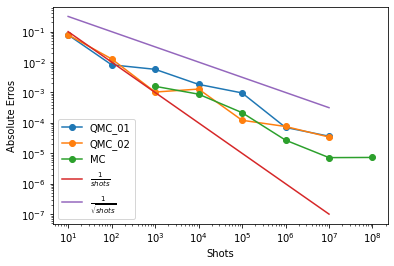

In [70]:
plt.plot(ListOfShots, abs(QMC_01-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots, abs(QMC_03-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots_MC, abs(MC-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots, 1.0/np.array(ListOfShots))
plt.plot(ListOfShots, 1.0/np.sqrt(np.array(ListOfShots)))
plt.xlabel('Shots')
plt.xscale('log')
plt.ylabel('Absolute Erros')
plt.yscale('log')    
plt.legend(['QMC_01', 'QMC_02', 'MC', r'$\frac{1}{shots}$', r'$\frac{1}{\sqrt{shots}}$'])

Como se puede ver en la gráfica anterior la convergencia de la integral buscada escala como $\frac{1}{\sqrt{N}}$ para el **Monte Carlo** clásico como para la verisión **cuántica**. Así que de momento no hemos ganado nada.

La idea es utilizar técnicas de $\textbf{AE}$ para mejorar esta convergencia!!

## 4. Algorithmos AE

Utilizando la librería **QQuantLib** podemos calcular la integral deseada sin más que proporcionar el oráculo!!

### 4.1 MLAE

In [71]:
from QQuantLib.AE.maximum_likelihood_ae import MLAE

In [72]:
target = standard_encoding.co_target
index = standard_encoding.co_index

In [79]:
index

[6]

In [80]:
mk_sched = [0, 4, 5, 9, 10, 14, 15, 19, 24, 29, 34, 39, 44, 49, 54, 59]
nk_sched = [200]*len(mk_sched)

mlae_dict = {
    'qpu': linalg_qpu,
    'mcz_qlm': True,
    'schedule': [mk_sched, nk_sched]
}
mlae = MLAE(
    standard_encoding.oracle,
    target = standard_encoding.co_target,
    index = standard_encoding.co_index, 
    **mlae_dict
)
ae = mlae.run()
integral_MLAE = ae*normalization*(2**n)
mlae_results = pd.DataFrame([mlae.m_k, mlae.n_k, mlae.h_k], index=['m_k', 'n_k', 'h_k']).T

In [81]:
from functools import partial
import scipy.optimize as so
def IncreasingSplitting(number_of_elements, number_of_slices = 5):
    
    if number_of_elements <= number_of_slices:
        raise ValueError('El numero de slices es menor que el de elementos.')   
    SplittingList = []
    #Initial Splitting
    Test = True
    division = 2
    while Test:
        #number of elements inside of the first split
        inner_elements = int(np.floor(number_of_elements / division))
        #print(half_elements)
        if number_of_elements - inner_elements < (number_of_slices-1):
            #If the number of elements in the outer part is lower than the 
            #number of slices - 1 we can not do the following splits
            #we need to change the initial splittings
            division = division + 1
        else:
            #If there is enough outer elements we can continue with the splitting
            Test = False
    #print('Initial inner_elements: '+ str(inner_elements))    
    #this is the mark for ending the spliting
    shift = inner_elements
    SplittingList.append(shift)
    #Rest of the splitings will be done iteratively
    Test = True
    division = 2
    number_of_slices = number_of_slices - 1
    i = 0
    while Test:
        #print('\t i: '+str(i))
        if number_of_slices == 1:
            SplittingList.append(number_of_elements)
            Test = False
        else:
            outer_elements = number_of_elements - shift
            #print('\t\t outer_elements: '+str(outer_elements))
            #print('\t\t remaining slices: '+str(number_of_slices-1))                          
            adding_elements = int(outer_elements / division) 
            inner_elements = shift + adding_elements
            future_outer_elements = number_of_elements - inner_elements 
            #print('\t\t future_outer_elements: '+str(future_outer_elements))
            if future_outer_elements < (number_of_slices - 1):
                #We need another try
                division = division + 1 
            else:
                #The splitting is good enough
                SplittingList.append(inner_elements)
                number_of_slices = number_of_slices - 1
                shift = inner_elements
                division = 2        
        i = i + 1
    return SplittingList

def log_likelihood(theta: float, m_k: int, n_k: int, h_k: int) -> float:
    r"""
    Calculates log of the likelihood from Suzuki papper.

    Notes
    -----
    .. math::
        \log{l_k(\theta|h_k)} = 2h_k\log\big[\sin\left((2m_k+1)\theta\right)\big]
        +2(n_k-h_k)\log\big[\cos\left((2m_k+1)\theta\right)\big]

    Parameters
    ----------

    theta : float
        Angle (radians) for calculating the probability of measure a
        positive event.
    m_k : int
        number of times the grover operator was applied.
    n_k : int
        number of total events measured for the specific  m_k
    h_k : int
        number of positive events measured for each m_k

    Returns
    ----------

    float
        Gives the log Likelihood p(h_k with m_k amplifications|theta)

    """
    theta_ = (2 * m_k + 1) * theta
    p_0 = np.sin(theta_) ** 2
    p_1 = np.cos(theta_) ** 2
    l_k = h_k * np.log(p_0) + (n_k - h_k) * np.log(p_1)
    return l_k

def cost_function(angle: float, m_k: list, n_k: list, h_k: list) -> float:
    r"""
    This method calculates the -Likelihood of angle theta
    for a given schedule m_k,n_k

    Notes
    -----
    .. math::
        L(\theta,\mathbf{h}) = -\sum_{k = 0}^M\log{l_k(\theta|h_k)}

    Parameters
    ----------

    angle: float
        Angle (radians) for calculating the probability of measure a
        positive event.
    m_k : list of ints
        number of times the grover operator was applied.
    n_k : list of ints
        number of total events measured for the specific  m_k
    h_k : list of ints
        number of positive events measured for each m_k

    Returns
    ----------

    cost : float
        the aggregation of the individual likelihoods
    """
    log_cost = 0
    # for i in range(len(m_k)):
    for i, _ in enumerate(m_k):
        log_l_k = log_likelihood(angle, m_k[i], n_k[i], h_k[i])
        log_cost = log_cost + log_l_k
    return -log_cost

def do_mlae_computations(mlae_pdf, delta = 1e-7, ns = 10000, optimizer=None):
    #Creamos la funcion parcial a partir de la Cost Function y de los resultados del MLAE
    cost_function_partial = partial(
        cost_function,
        m_k = list(mlae_pdf['m_k']),
        n_k = list(mlae_pdf['n_k']),
        h_k = list(mlae_pdf['h_k'])             
    )
    #configuramos el optimizador
    theta_domain = [(0 + delta, 0.5 * np.pi - delta)]
    if optimizer is None:
        optimizer = lambda x: so.brute(x, ranges = theta_domain, Ns=ns)
        #Optimizamos
        theta = optimizer(cost_function_partial)[0]
    else:
        theta = optimizer(cost_function_partial).x[0]
        print(theta)
        
    #print(theta)
    ae = np.sin(theta)**2
    return ae



def do_staff(mlae_results, delta = 1e-7, ns = 10000, number_of_slices = 5, min_meas = None, optimizer=None):
    
    if min_meas is not None:
        mlae_results = mlae_results[mlae_results['h_k'] >= min_meas]
    splits = IncreasingSplitting(len(mlae_results), number_of_slices = number_of_slices)
    #print(mlae_results)
    list_of_mlae = []
    list_of_ae = []
    for i in range(len(mlae_results)):
        list_of_mlae.append(mlae_results[:i+1])
        step_ae = do_mlae_computations(mlae_results[:i], delta = delta, ns = ns, optimizer = optimizer)
        oracle_call_shots = np.sum(mlae_results[:i]['n_k']*(2*mlae_results[:i]['m_k']+1))
        list_of_ae.append([oracle_call_shots, step_ae])
    pdf = pd.DataFrame(list_of_ae)
    pdf.rename(columns = {0: 'oracle_calls', 1:'ae'}, inplace=True)
    return pdf

In [82]:
bounds = [[0.+mlae.delta,np.pi/2-mlae.delta]]
differential_evolution = lambda f: so.differential_evolution(f,bounds = bounds)
kk = do_staff(mlae_results, number_of_slices=6, delta = 1e-8, ns = 10000, min_meas = 50, optimizer = differential_evolution)
kk['integral_mlae'] = kk['ae']*normalization*(2**n)
kk['error'] = np.abs(kk['integral_mlae']-np.sum(g_x))

0.9094437365231773
1.1945591307824521
1.199298473558535
1.2492493774461637
1.2487256069067176
1.2488178283072384
1.2494120298707276
1.249567426685889
1.2493616907755851
1.249575820875425
1.249427428824822
1.2496250236795308
1.2495076932764644
1.2496407290238507
1.2496853807294157
1.2496121101640962


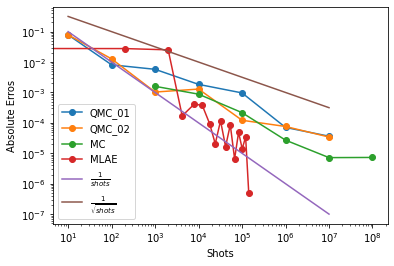

In [84]:
plt.plot(ListOfShots, abs(QMC_01-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots, abs(QMC_03-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots_MC, abs(MC-sin_integral(a,b)), 'o-')
plt.plot(kk['oracle_calls'], kk['error'], 'o-')
plt.plot(ListOfShots, 1.0/np.array(ListOfShots))
plt.plot(ListOfShots, 1.0/np.sqrt(np.array(ListOfShots)))
plt.xlabel('Shots')
plt.xscale('log')
plt.ylabel('Absolute Erros')
plt.yscale('log')    
plt.legend(['QMC_01', 'QMC_02', 'MC', 'MLAE', r'$\frac{1}{shots}$', r'$\frac{1}{\sqrt{shots}}$'])

## IQAE

In [85]:
from QQuantLib.AE.iterative_quantum_ae import IQAE

In [93]:
epsilon_list = [0.01, 0.01, 0.001, 0.0001, 0.00001]


shots = 100
alpha = 0.05
iqae_list = []
for epsilon in epsilon_list:
    iqae_dict = {
        'epsilon': epsilon,
        'shots': shots,
        'alpha': alpha,
        'qpu': linalg_qpu,
        'mcz_qlm': True       
    }
    iqae = IQAE(standard_encoding.oracle, target = standard_encoding.co_target, index = standard_encoding.co_index, **iqae_dict)
    iqae.run()
    step_pdf = pd.DataFrame.from_dict(iqae.schedule, orient='index', columns=['shots']).reset_index()
    step_pdf.rename(columns={'index': 'm_k'}, inplace=True)
    oracle_shots = np.sum((2*step_pdf['m_k']+1)*step_pdf['shots'])
    step = iqae.ae *normalization*(2**n)
    iqae_list.append([oracle_shots, step])

In [91]:
iqae.ae

0.500002244802569

In [94]:
iqae_pdf = pd.DataFrame(iqae_list)

In [95]:
iqae_pdf[2] = np.abs(iqae_pdf[1]-np.sum(g_x))

In [92]:
np.sum(g_x)

0.7070979070795471

In [96]:
iqae_pdf

,0,1,2
0,5900,0.706857,0.000240
1,4200,0.705179,0.001919
2,94600,0.707098,0.000000
3,405900,0.707094,0.000004
4,5608300,0.707097,0.000001


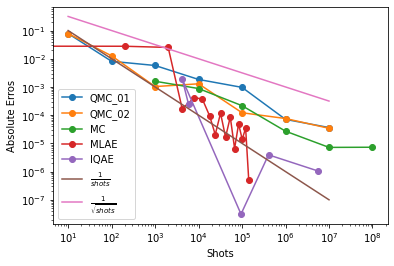

In [97]:
plt.plot(ListOfShots, abs(QMC_01-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots, abs(QMC_03-sin_integral(a,b)), 'o-')
plt.plot(ListOfShots_MC, abs(MC-sin_integral(a,b)), 'o-')
plt.plot(kk['oracle_calls'], kk['error'], 'o-')
plt.plot(iqae_pdf[0], iqae_pdf[2], 'o-')

plt.plot(ListOfShots, 1.0/np.array(ListOfShots))
plt.plot(ListOfShots, 1.0/np.sqrt(np.array(ListOfShots)))
plt.xlabel('Shots')
plt.xscale('log')
plt.ylabel('Absolute Erros')
plt.yscale('log')    
plt.legend(['QMC_01', 'QMC_02', 'MC', 'MLAE', 'IQAE', r'$\frac{1}{shots}$', r'$\frac{1}{\sqrt{shots}}$'])

In [ ]:
oracle_shots

In [ ]:
[step-np.sum(g_x)]